Partie 3 : Modélisation
========================

Objectifs
---------
- Implémenter un modèle de filtrage collaboratif (User-Based)
- Implémenter un modèle basé sur le contenu (Content-Based)
- Implémenter un modèle hybride (ML supervisé)
- Comparer les trois approches


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


Chargement des Données
----------------------


In [28]:
# Charger users.csv
users_df = pd.read_csv("/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/users.csv")

# Charger products.csv
products_df = pd.read_csv("/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/products.csv")

# Charger interactions.csv
interactions_df = pd.read_csv("/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/interactions.csv")


In [29]:

# Charger users_processed.csv
users_processed_df = pd.read_csv("/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/users_processed.csv")

# Charger products_processed.csv
products_processed_df = pd.read_csv("/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/products_processed.csv")

# Charger interactions_processed.csv
interactions_processed_df = pd.read_csv("/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/interactions_processed.csv")

In [18]:
# DATA_PATH = "../data/"

# users_df = pd.read_csv(DATA_PATH + 'users.csv')
# products_df = pd.read_csv(DATA_PATH + 'products.csv')
# interactions_df = pd.read_csv(DATA_PATH + 'interactions.csv')

# Conversion des dates
users_df['registration_date'] = pd.to_datetime(users_df['registration_date'])
products_df['added_date'] = pd.to_datetime(products_df['added_date'])
interactions_df['interaction_date'] = pd.to_datetime(interactions_df['interaction_date'])


3.1 - Filtrage Collaboratif (User-Based)
------------------------------------------

Recommander les produits appréciés par des utilisateurs similaires.

Étapes :
1. Créer une matrice utilisateur-produit
2. Calculer la similarité entre utilisateurs
3. Prédire les scores pour les produits non vus
4. Recommander le top-K produits


In [30]:
# TODO : Créer la matrice utilisateur-produit

# Créer la matrice (utilisateurs en lignes, produits en colonnes)
user_item_matrix = interactions_df.pivot_table(
    index='user_id',
    columns='product_id',
    aggfunc='size',      # Compte le nombre d'interactions
    fill_value=0         # Remplit les interactions inexistantes avec 0
)

print(f"Matrice user-item : {user_item_matrix.shape}")
print(f"Sparsité : {(user_item_matrix == 0).sum().sum() / user_item_matrix.size * 100:.2f}%")


Matrice user-item : (4974, 1000)
Sparsité : 99.01%


In [31]:
from sklearn.metrics.pairwise import cosine_similarity # Assurez-vous que c'est importé
# TODO : Calculer la similarité entre utilisateurs

# Utiliser cosine_similarity
user_similarity = cosine_similarity(user_item_matrix)

print(f"Matrice de similarité : {user_similarity.shape}")
print("Similarité calculée")


Matrice de similarité : (4974, 4974)
Similarité calculée


In [ ]:
# TODO : Fonction de recommandation

def recommend_user_based(user_id, user_item_matrix, user_similarity, k_neighbors=10, n_recommendations=5):
    """
    Recommande des produits basés sur le filtrage collaboratif
    
    Args:
        user_id: ID de l'utilisateur
        user_item_matrix: Matrice utilisateur-produit
        user_similarity: Matrice de similarité
        k_neighbors: Nombre de voisins à considérer
        n_recommendations: Nombre de recommandations
    
    Returns:
        Liste des product_ids recommandés
    """
    # VOTRE CODE ICI
    pass

# Test
test_user = users_df['user_id'].iloc[0]
recommendations_cf = recommend_user_based(test_user, user_item_matrix, user_similarity)
print(f"Recommandations pour l'utilisateur {test_user} :")
print(recommendations_cf)


In [32]:
import numpy as np
import pandas as pd # Nécessaire pour créer la Série de scores

# TODO : Fonction de recommandation

def recommend_user_based(user_id, user_item_matrix, user_similarity, k_neighbors=10, n_recommendations=5):
    """
    Recommande des produits basés sur le filtrage collaboratif
    
    Args:
        user_id: ID de l'utilisateur
        user_item_matrix: Matrice utilisateur-produit
        user_similarity: Matrice de similarité (NumPy array)
        k_neighbors: Nombre de voisins à considérer
        n_recommendations: Nombre de recommandations
    
    Returns:
        Liste des product_ids recommandés
    """
    
    try:
        # 1. Obtenir la position (index entier) de l'utilisateur dans la matrice
        user_position = user_item_matrix.index.get_loc(user_id)
    except KeyError:
        print(f"L'utilisateur {user_id} n'existe pas dans la matrice.")
        return []

    # 2. Obtenir les scores de similarité de cet utilisateur avec tous les autres
    user_sim_scores = user_similarity[user_position]

    # 3. Obtenir les positions des k voisins les plus similaires
    # np.argsort trie et donne les indices. [::-1] inverse l'ordre (décroissant)
    # [1:k_neighbors+1] prend les k suivants (on saute [0] qui est l'utilisateur lui-même)
    top_neighbor_indices = np.argsort(user_sim_scores)[::-1][1:k_neighbors+1]
    
    # 4. Obtenir les scores de similarité de ces k voisins
    top_neighbor_scores = user_sim_scores[top_neighbor_indices]

    # 5. Obtenir les interactions de ces k voisins
    neighbor_interactions = user_item_matrix.iloc[top_neighbor_indices]

    # 6. Calculer le score pondéré des recommandations
    # On multiplie les interactions de chaque voisin par son score de similarité
    # .dot() fait la somme pondérée pour nous
    weighted_scores_np = top_neighbor_scores.dot(neighbor_interactions)
    
    # 7. Convertir en Série Pandas pour avoir les product_id comme index
    weighted_scores = pd.Series(weighted_scores_np, index=user_item_matrix.columns)

    # 8. Filtrer les produits que l'utilisateur a déjà vus
    user_seen_items_row = user_item_matrix.loc[user_id]
    seen_items_list = user_seen_items_row[user_seen_items_row > 0].index
    
    # On utilise .drop() pour retirer les produits déjà vus
    final_recommendations = weighted_scores.drop(seen_items_list, errors='ignore')

    # 9. Obtenir le top N
    top_n = final_recommendations.sort_values(ascending=False).head(n_recommendations)

    # 10. Retourner la liste des product_id
    return top_n.index.tolist()

# Test
# On utilise user_item_matrix.index[0] pour être sûr d'avoir un ID valide
test_user = user_item_matrix.index[0] 
recommendations_cf = recommend_user_based(test_user, user_item_matrix, user_similarity)
print(f"Recommandations pour l'utilisateur {test_user} :")
print(recommendations_cf)

Recommandations pour l'utilisateur 1 :
[185, 478, 298, 669, 192]


3.2 - Filtrage par Contenu (Content-Based)
--------------------------------------------

Recommander des produits similaires à ceux déjà appréciés.

Étapes :
1. Créer des embeddings de produits (TF-IDF)
2. Calculer la similarité entre produits
3. Recommander des produits similaires


In [33]:
# TODO : Créer un corpus textuel pour chaque produit

# Combiner nom, description, catégorie
products_df['content'] = (
    products_df['name'].fillna('') + ' ' +
    products_df['description'].fillna('') + ' ' +
    products_df['category'].fillna('')
)

# Créer les embeddings TF-IDF
tfidf = TfidfVectorizer(max_features=200, stop_words='english')
# Appliquer fit_transform sur la colonne 'content'
product_vectors = tfidf.fit_transform(products_df['content'])

print(f"Vecteurs TF-IDF : {product_vectors.shape}")


Vecteurs TF-IDF : (1000, 89)


In [34]:
from sklearn.metrics.pairwise import cosine_similarity # Assurez-vous que c'est importé
# TODO : Calculer la similarité entre produits

product_similarity = cosine_similarity(product_vectors)

print(f"Matrice de similarité produits : {product_similarity.shape}")
print("Similarité calculée")


Matrice de similarité produits : (1000, 1000)
Similarité calculée


In [35]:
# TODO : Fonction de recommandation content-based

def recommend_content_based(user_id, interactions_df, products_df, product_similarity, n_recommendations=5):
    """
    Recommande des produits basés sur le contenu
    
    Args:
        user_id: ID de l'utilisateur
        interactions_df: DataFrame des interactions
        products_df: DataFrame des produits
        product_similarity: Matrice de similarité (NumPy array)
        n_recommendations: Nombre de recommandations
    
    Returns:
        Liste des product_ids recommandés
    """
    
    # 1. Trouver l'historique d'interaction (product_id) de l'utilisateur
    user_product_ids = interactions_df[
        interactions_df['user_id'] == user_id
    ]['product_id'].unique()
    
    if len(user_product_ids) == 0:
        print(f"L'utilisateur {user_id} n'a pas d'historique.")
        return []

    # 2. Créer un mapping de 'product_id' à 'index de matrice' (0, 1, 2...)
    # C'est l'étape la plus importante
    product_id_to_index = pd.Series(range(len(products_df)), index=products_df['product_id'])

    # 3. Convertir l'historique (product_id) en indices de matrice
    user_product_indices = product_id_to_index.get(user_product_ids, default=None)
    # Filtrer les 'None' si un product_id de l'interaction n'est pas dans products_df
    user_product_indices = [idx for idx in user_product_indices if idx is not None]

    if len(user_product_indices) == 0:
        print(f"L'historique de l'utilisateur {user_id} ne correspond à aucun produit traitable.")
        return []

    # 4. Obtenir les scores de similarité pour l'historique de l'utilisateur
    # On prend toutes les lignes de la matrice de similarité qui correspondent à l'historique
    history_similarities = product_similarity[user_product_indices]

    # 5. Calculer le score de recommandation moyen
    # On fait la moyenne (axis=0) de ces scores pour obtenir un score global pour chaque produit
    combined_scores = history_similarities.mean(axis=0)

    # 6. Mettre les scores dans une Série Pandas pour les lier au product_id
    scores_series = pd.Series(combined_scores, index=products_df['product_id'])

    # 7. Filtrer les produits que l'utilisateur a DÉJÀ vus
    final_recommendations = scores_series.drop(user_product_ids, errors='ignore')
    
    # 8. Obtenir le top N
    top_n = final_recommendations.sort_values(ascending=False).head(n_recommendations)

    # 9. Retourner la liste des product_ids
    return top_n.index.tolist()

# Test
# On s'assure que test_user existe
try:
    test_user
except NameError:
    test_user = interactions_df['user_id'].iloc[0]

recommendations_content = recommend_content_based(test_user, interactions_df, products_df, product_similarity)
print(f"Recommandations content-based pour l'utilisateur {test_user} :")
print(recommendations_content)


Recommandations content-based pour l'utilisateur 1 :
[540, 2, 285, 341, 348]


3.3 - Modèle Hybride (ML Supervisé)
-------------------------------------

Combiner features utilisateurs et produits dans un modèle supervisé.

Étapes :
1. Créer un dataset d'entraînement (user + product + target)
2. Entraîner un modèle (RandomForest)
3. Prédire les probabilités d'interaction


In [36]:
# TODO : Créer le dataset d'entraînement

# --- 1. Utiliser le DataFrame d'interactions traité comme base ---
# Il contient déjà les 'user_id', 'product_id', 'rating' et 'session_duration' traités
data_ml = interactions_processed_df.copy()

# On a besoin de la date (pour le split temporel) et du type (pour la cible)
# On les récupère depuis le dataframe original
data_ml['interaction_date'] = interactions_df['interaction_date']
data_ml['interaction_type_raw'] = interactions_df['interaction_type']


# --- 2. Créer la cible (Target) ---
# 1 = Interaction positive (achat, ajout au panier)
# 0 = Interaction de base (vue)
positive_types = ['purchase', 'add_to_cart']
negative_type = 'view'

# Crée la colonne 'target'
data_ml['target'] = np.where(data_ml['interaction_type_raw'].isin(positive_types), 1, 0)

# On ne garde que les lignes qui nous intéressent (vues ou interactions positives)
data_ml = data_ml[
    data_ml['interaction_type_raw'].isin(positive_types + [negative_type])
].copy()


# --- 3. Fusionner pour obtenir toutes les features ---
# Ajouter les features de l'utilisateur
data_ml = pd.merge(data_ml, users_processed_df, on='user_id', suffixes=('', '_user'))
# Ajouter les features du produit
data_ml = pd.merge(data_ml, products_processed_df, on='product_id', suffixes=('', '_prod'))


# --- 4. Split temporel (80% train, 20% test) ---
# C'est la méthode correcte : on s'entraîne sur le passé pour prédire l'avenir
print("Tri du dataset par date...")
data_ml = data_ml.sort_values(by='interaction_date')

# Calculer le point de séparation (80%)
split_point = int(len(data_ml) * 0.8)

# Séparer les dataframes
train_df = data_ml.iloc[:split_point]
test_df = data_ml.iloc[split_point:]


# --- 5. Définir X (features) et y (target) ---

# On définit la liste de toutes nos features traitées
# (On exclut les ID, dates, et colonnes de texte brutes)
interaction_features = ['rating', 'session_duration']
user_features = [col for col in users_processed_df.columns if col not in ['user_id']]
product_features = [col for col in products_processed_df.columns if col not in 
                    ['product_id', 'name', 'description', 'content', 'added_date']] # Exclure aussi les originaux

feature_cols = interaction_features + user_features + product_features
target_col = 'target'

# Créer les jeux finaux
X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col] # On crée y_test pour l'évaluation plus tard

print("Dataset créé")
print(f"Train : {X_train.shape}")
print(f"Test : {X_test.shape}")
print(f"Répartition de la cible (train) :\n{y_train.value_counts(normalize=True)}")


Tri du dataset par date...
Dataset créé
Train : (39189, 20)
Test : (9798, 20)
Répartition de la cible (train) :
target
0    0.714639
1    0.285361
Name: proportion, dtype: float64


In [40]:
# TODO : Entraîner le modèle

model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
# Entraîner le modèle sur le jeu d'entraînement
model_rf.fit(X_train, y_train)

# Évaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prédire les étiquettes sur le jeu de test
y_pred = model_rf.predict(X_test)

print("Performance du modèle :")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision : {precision_score(y_test, y_pred):.3f}")
print(f"Recall : {recall_score(y_test, y_pred):.3f}")
print(f"F1-Score : {f1_score(y_test, y_pred):.3f}")

Performance du modèle :
Accuracy : 0.989
Precision : 0.963
Recall : 1.000
F1-Score : 0.981


Top 10 Features :
               feature  importance
1     session_duration    0.846626
0               rating    0.121734
8         panier_moyen    0.004333
7        nombre_achats    0.003880
16  product_conversion    0.003334
6        total_depense    0.003263
12               price    0.002341
2                  age    0.002194
13               stock    0.002039
4             location    0.001464


<Figure size 1000x600 with 0 Axes>

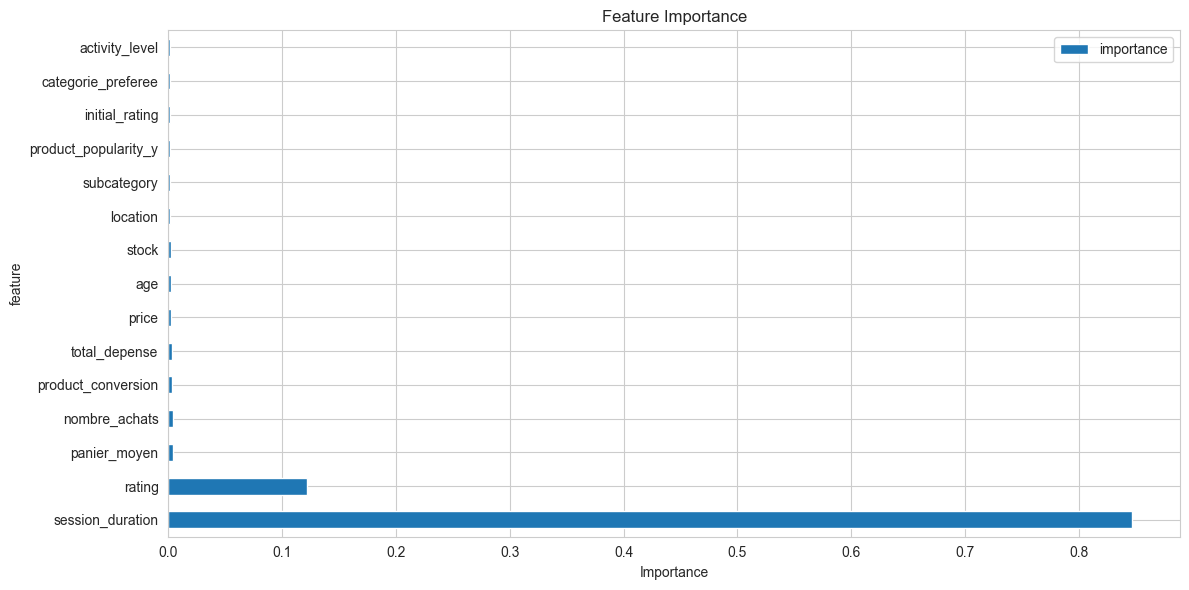

In [ ]:
# TODO : Feature Importance

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Features :")
print(feature_importance.head(10))

# Visualisation
plt.figure(figsize=(10, 6))
feature_importance.head(15).plot(x='feature', y='importance', kind='barh')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


Prochaines Étapes
-----------------

Passez au notebook 04_Evaluation_starter.ipynb pour évaluer et comparer les trois modèles avec des métriques adaptées.
